# Lithium Ion Battery Capacity Estimation using Autoencoders and Ensemble Learning





#### Author: Susmitha Ganesh

## Data Processing File

Goal: Preprocessing Data from Charge Profiles of Different batteries.

Procedure: Read Data and Preprocessing

### Read Data

 - multiple charging profile files, 4 batteries
 * Indices identified
 * read the voltage and temperature data into pandas dataframe
 * Convert each of the file into an ndarray
 * verify if the max time is 4096s. If not throw an error.
 * Plot all the charge curves,

### Preprocessing

* resample and verify the pattern
* pick only 512 samples of both voltage and temperature.
* concatenate to one ndarray of shape (n,512,2).
* get all the capacity values and create a ndarray of shape nx1.

* Build train and test data.
* Normalize (min-max scaling).


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip /content/drive/My\ Drive/EE297B_Folder/Project_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data_on_drive/data/02743.csv  
  inflating: __MACOSX/Data_on_drive/data/._02743.csv  
  inflating: Data_on_drive/data/04332.csv  
  inflating: __MACOSX/Data_on_drive/data/._04332.csv  
  inflating: Data_on_drive/data/00154.csv  
  inflating: __MACOSX/Data_on_drive/data/._00154.csv  
  inflating: Data_on_drive/data/06525.csv  
  inflating: __MACOSX/Data_on_drive/data/._06525.csv  
  inflating: Data_on_drive/data/02970.csv  
  inflating: __MACOSX/Data_on_drive/data/._02970.csv  
  inflating: Data_on_drive/data/05979.csv  
  inflating: __MACOSX/Data_on_drive/data/._05979.csv  
  inflating: Data_on_drive/data/00801.csv  
  inflating: __MACOSX/Data_on_drive/data/._00801.csv  
  inflating: Data_on_drive/data/00815.csv  
  inflating: __MACOSX/Data_on_drive/data/._00815.csv  
  inflating: Data_on_drive/data/02964.csv  
  inflating: __MACOSX/Data_on_drive/data/._02964.csv  
  inflating: Data_on_drive/data/02794.csv  
  inflating: _

Code automation to extract the data from all the files and concatenate.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ------  Specify the parameters ------------
num_samples = 512
desired_interval_seconds = 8
X_list = []
Y_list = []


# ------ Select the Battery -----------------
# B0005
Data = 'idx_B0005_charge.npy'
# # B0006
# Data = 'idx_B0006_charge.npy'
# # B0007
# Data = 'idx_B0007_charge.npy'
# # B0018
# Data = 'idx_B0018_charge.npy'


#---------- Load the indices from the file ------------
Batt_idx = np.load('/content/Data_on_drive/Identified_indices/'+Data, allow_pickle = True)

for file in Batt_idx:
  df_data = pd.read_csv('/content/Data_on_drive/data/'+file)

  max_time = df_data['Time'].max()
  if max_time < 4096:
    print("Error: The time is less than 4096s for file: ", file)
    continue

  #--------------------- Data Cleaning -----------------------------
  if df_data.isnull().values.any():
    print("Error: DataFrame contains NaN values in file: ", file)
    df_data.dropna(inplace=True)

  #--------------- Creating Expected capacity output Y -------------
  sum_currentXtime = 0
  previous_time = None

  for index, row in df_data.iterrows():
    if previous_time is not None:
      delta_time = row['Time'] - previous_time
      sum_currentXtime += row['Current_measured'] * delta_time

    previous_time = row['Time']

  Capacity = sum_currentXtime / 3600
  Y_list.append(Capacity)
  #-----------------------------------------------------------------

  #--------------------- Data Cleaning -----------------------------
  df_data.drop(['Current_measured', 'Current_charge', 'Voltage_charge'], axis=1, inplace=True)




#--------------------- Resample ------------------------
  df_data['CopyTime'] = df_data['Time']
  df_data['Time'] = pd.to_timedelta(df_data['Time'], unit='s')
  df_data.set_index('Time', inplace=True)

  desired_interval = pd.to_timedelta(desired_interval_seconds, unit='s')

# Resample the DataFrame using the calculated interval
  resampled_df_data = df_data.resample(desired_interval).mean().interpolate(method='linear')

# Select the first `num_samples` points
  resampled_df_data = resampled_df_data.iloc[:num_samples]


#--------------------- Plot -----------------------------
  # fig, axes = plt.subplots(2, 1, figsize=(5,5))

  # # Voltage Measured
  # axes[0].plot(resampled_df_data.index.total_seconds(),resampled_df_data['Voltage_measured'])
  # axes[0].plot(df_data['CopyTime'], df_data['Voltage_measured'], '--r')
  # axes[0].set_title('Voltage Measured')
  # axes[0].set_ylabel('Voltage')
  # axes[0].legend(['Resampled', 'Original'])

  # # Temperature Measured
  # axes[1].plot(resampled_df_data.index.total_seconds(), resampled_df_data['Temperature_measured'])
  # axes[1].plot(df_data['CopyTime'], df_data['Temperature_measured'], '--r')
  # axes[1].set_title('Temperature Measured')
  # axes[1].set_ylabel('Temperature')
  # axes[1].set_xlabel('Time')
  # axes[1].legend(['Resampled', 'Original'])

  # plt.tight_layout()
  # filename = file.replace('.csv', '')
  # plt.savefig('/content/Data_on_drive'+filename+'.png')
  # plt.close()


# Creating input (pandas dataframe to numpy ndarray)
  X = resampled_df_data[['Voltage_measured', 'Temperature_measured']].values


#------------------ Normalization -------------------------
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  if (X_scaled.shape == (512,2)):
    X_list.append(X_scaled)



Error: The time is less than 4096s for file:  04589.csv
Error: The time is less than 4096s for file:  05120.csv


In [ ]:
X_list_B005 = np.array(X_list)
print(X_list_B005.shape)
X_list_B005 = X_list_B005.reshape(-1, 512, 2)
print(X_list_B005.shape)

(168, 512, 2)
(168, 512, 2)


In [ ]:
Y_list_B005 = np.array(Y_list)
Y_list_B005 = Y_list_B005.reshape(-1)
Y_list_B005.shape

(168,)

In [ ]:
print(Y_list_B005)

[0.77612415 1.87794915 1.87085697 1.86334694 1.86070267 1.86099222
 1.85944844 1.86137611 1.84939144 1.85032171 1.84893639 1.85004508
 1.72317697 1.83715272 1.83798468 1.83839222 1.82748243 1.82721893
 1.82681776 1.82734366 1.82072376 1.87484005 1.87464416 1.86241794
 1.85330569 1.85235551 1.8527137  1.83989492 1.84183051 1.84022638
 1.82883003 1.83338771 1.84647036 1.83440476 1.82320672 1.81339695
 1.80850834 1.80247118 1.79315244 1.78712948 1.77720302 1.77596271
 1.77107629 1.76600346 1.77678401 1.76587636 1.75541693 1.74514064
 1.73704457 1.8081928  1.78517952 1.77015071 1.76202382 1.74991802
 1.74496984 1.73931519 1.72860785 1.71980219 1.71313708 1.70818511
 1.70237404 1.69719716 1.68834178 1.67667134 1.67732487 1.67121678
 1.66119485 1.65581134 1.64464626 1.6414155  1.63518717 1.62988262
 1.62468333 1.61351407 1.60822298 1.60473895 1.59351872 1.5875646
 1.5841585  1.59751195 1.57804769 1.56698775 1.56124995 1.56118577
 1.55555589 1.55112387 1.53978976 1.53023822 1.53210109 1.52501

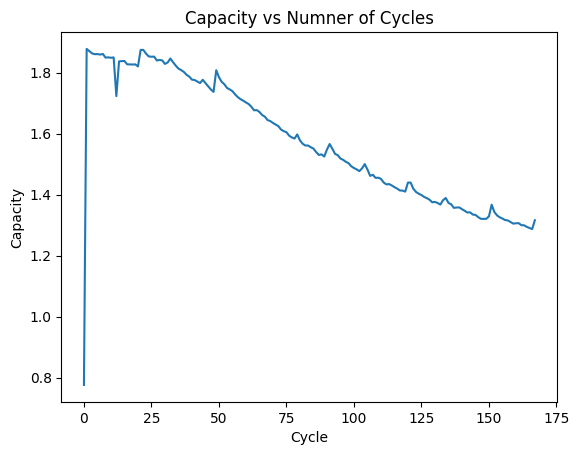

In [ ]:
plt.plot(Y_list_B005)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Numner of Cycles')
plt.show()

In [ ]:
if len(Y_list_B005) > 0 and len(X_list_B005) > 0:
  Y_list_B005 = Y_list_B005[1:]
  X_list_B005 = X_list_B005[1:]

In [ ]:
print(Y_list_B005.shape)
print(X_list_B005.shape)

(167,)
(167, 512, 2)


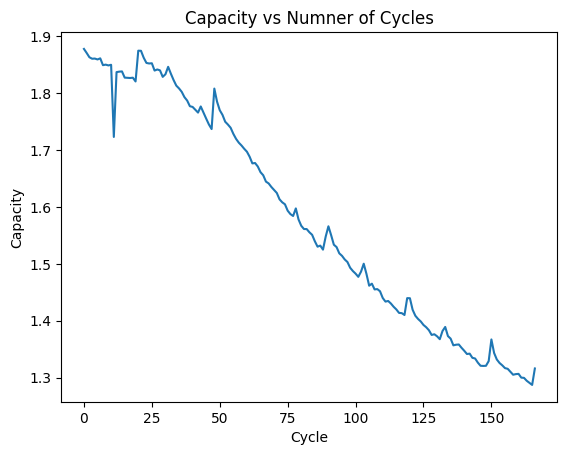

In [ ]:
plt.plot(Y_list_B005)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Numner of Cycles')
plt.show()

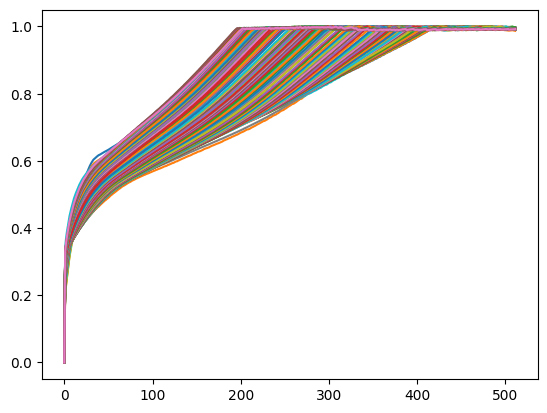

In [ ]:
for i in range(X_list_B005.shape[0]):
  plt.plot(X_list_B005[i, :, 0])
plt.show()

In [ ]:
X_list_B007 = np.array(X_list)
print(X_list_B007.shape)
X_list_B007 = X_list_B007.reshape(-1, 512, 2)
print(X_list_B007.shape)

(168, 512, 2)
(168, 512, 2)


In [ ]:
Y_list_B007 = np.array(Y_list)
Y_list_B007 = Y_list_B007.reshape(-1)
Y_list_B007.shape

(168,)

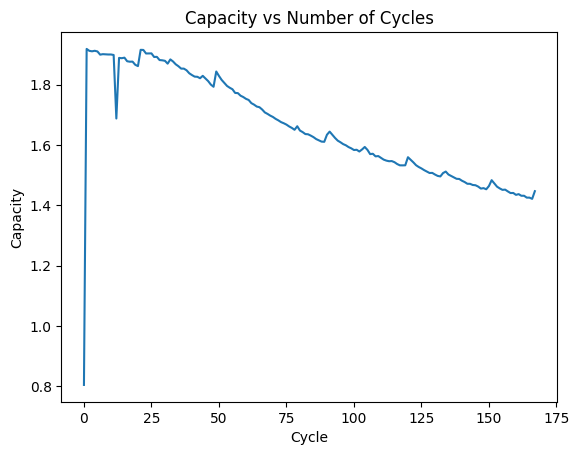

In [ ]:
plt.plot(Y_list_B007)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

In [ ]:
if len(Y_list_B007) > 0 and len(X_list_B007) > 0:
  Y_list_B007 = Y_list_B007[1:]
  X_list_B007 = X_list_B007[1:]

In [ ]:
print(Y_list_B007.shape)
print(X_list_B007.shape)

(167,)
(167, 512, 2)


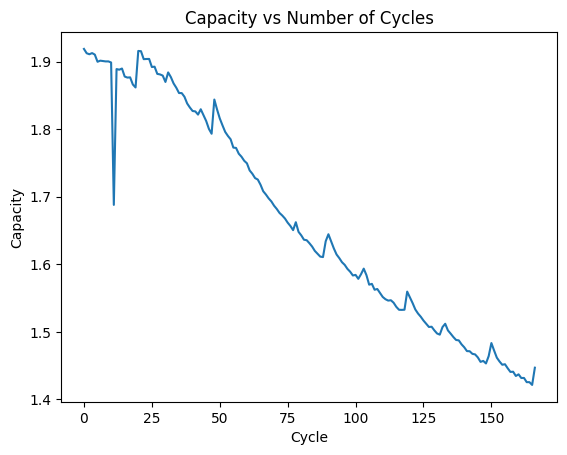

In [ ]:
plt.plot(Y_list_B007)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

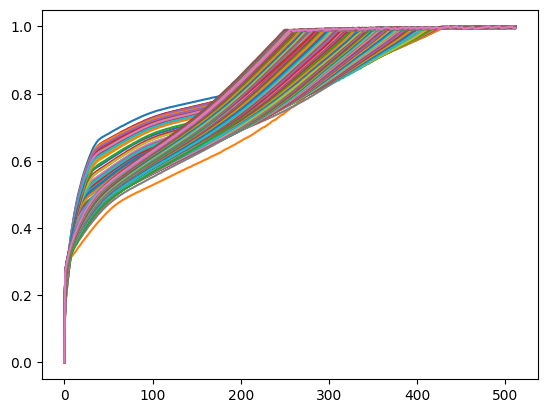

In [ ]:
for i in range(X_list_B007.shape[0]):
  plt.plot(X_list_B007[i, :, 0])
plt.show()

In [ ]:
X_list_B006 = np.array(X_list)
print(X_list_B006.shape)
X_list_B006 = X_list_B006.reshape(-1, 512, 2)
print(X_list_B006.shape)

(168, 512, 2)
(168, 512, 2)


In [ ]:
Y_list_B006 = np.array(Y_list)
Y_list_B006 = Y_list_B006.reshape(-1)
Y_list_B006.shape

(168,)

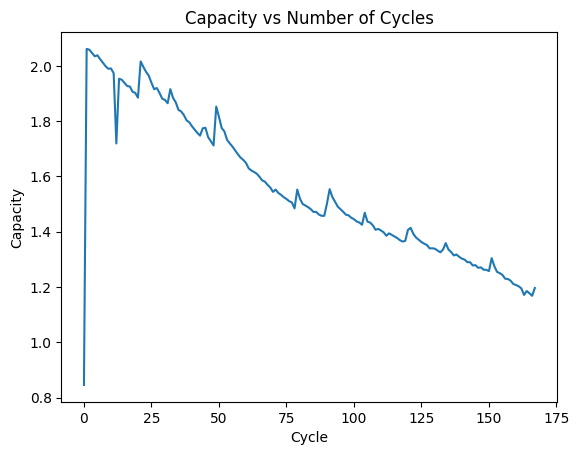

In [ ]:
plt.plot(Y_list_B006)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

In [ ]:
if len(Y_list_B006) > 0 and len(X_list_B006) > 0:
  Y_list_B006 = Y_list_B006[1:]
  X_list_B006 = X_list_B006[1:]

In [ ]:
print(Y_list_B006.shape)
print(X_list_B006.shape)

(167,)
(167, 512, 2)


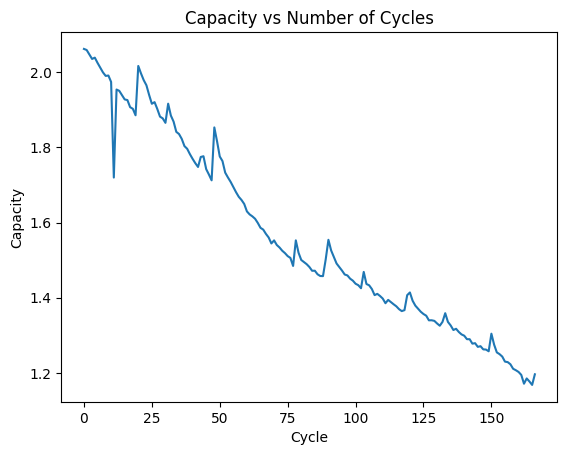

In [ ]:
plt.plot(Y_list_B006)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

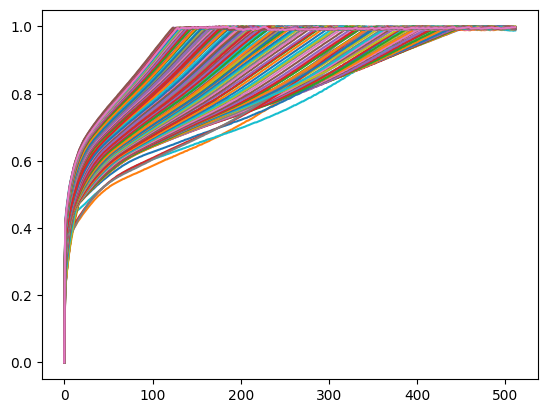

In [ ]:
for i in range(X_list_B006.shape[0]):
  plt.plot(X_list_B006[i, :, 0])
plt.show()

In [ ]:
X_list_B018 = np.array(X_list)
print(X_list_B018.shape)
X_list_B018 = X_list_B018.reshape(-1, 512, 2)
print(X_list_B018.shape)

(133, 512, 2)
(133, 512, 2)


In [ ]:
Y_list_B018 = np.array(Y_list)
Y_list_B018 = Y_list_B018.reshape(-1)
Y_list_B018.shape

(133,)

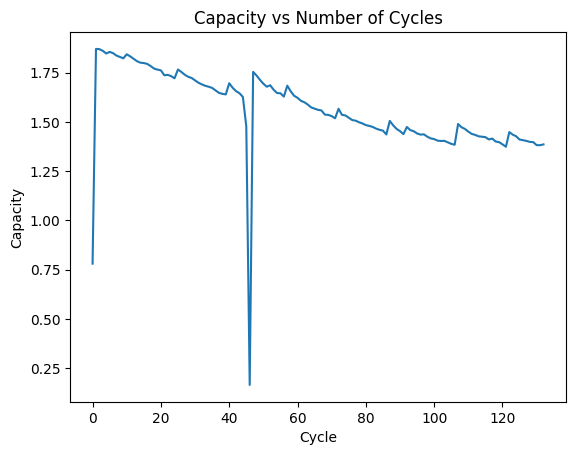

In [ ]:
plt.plot(Y_list_B018)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

In [ ]:
if len(Y_list_B018) > 0 and len(X_list_B018) > 0:
  Y_list_B018 = Y_list_B018[1:]
  X_list_B018 = X_list_B018[1:]

In [ ]:
print(Y_list_B018.shape)
print(X_list_B018.shape)

(132,)
(132, 512, 2)


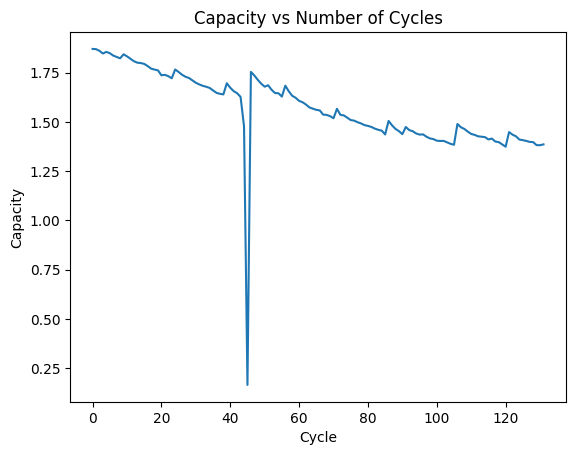

In [ ]:
plt.plot(Y_list_B018)
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.title('Capacity vs Number of Cycles')
plt.show()

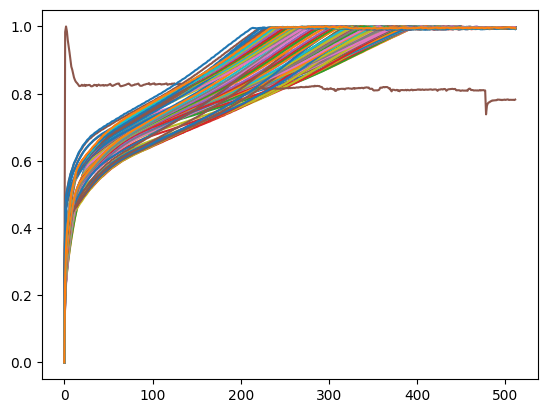

In [ ]:
for i in range(X_list_B018.shape[0]):
  plt.plot(X_list_B018[i, :, 0])
plt.show()

In [ ]:
rows_to_delete = []
for i in range(X_list_B018.shape[0]):
  if(X_list_B018[i, 511, 0]< 0.9):
    print(i)
    rows_to_delete.append(i)

45


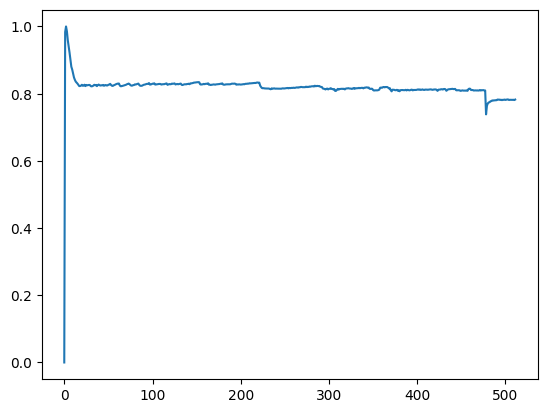

In [ ]:
plt.plot(X_list_B018[45, :, 0])

In [ ]:
X_list_B018 = np.delete(X_list_B018, rows_to_delete, axis=0)
Y_list_B018 = np.delete(Y_list_B018, rows_to_delete, axis=0)
print(X_list_B018.shape)
print(Y_list_B018.shape)


(131, 512, 2)
(131,)


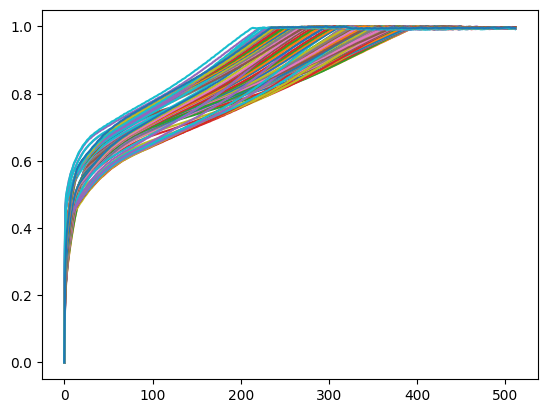

In [ ]:
for i in range(X_list_B018.shape[0]):
  plt.plot(X_list_B018[i, :, 0])
plt.show()

In [ ]:
# save X_list_B005, Y_list_B005, X_list_B006, Y_list_B006, X_list_B007, Y_list_B007, X_list_B018, Y_list_B018 on disk

import numpy as np

np.save('/content/drive/MyDrive/X_list_B005.npy', X_list_B005)
np.save('/content/drive/MyDrive/Y_list_B005.npy', Y_list_B005)
np.save('/content/drive/MyDrive/X_list_B006.npy', X_list_B006)
np.save('/content/drive/MyDrive/Y_list_B006.npy', Y_list_B006)
np.save('/content/drive/MyDrive/X_list_B007.npy', X_list_B007)
np.save('/content/drive/MyDrive/Y_list_B007.npy', Y_list_B007)
np.save('/content/drive/MyDrive/X_list_B018.npy', X_list_B018)
np.save('/content/drive/MyDrive/Y_list_B018.npy', Y_list_B018)

In [ ]:
# load X_list_B005.npy, Y_list_B005.npy, X_list_B006.npy, Y_list_B006.npy, X_list_B007.npy, Y_list_B007.npy, X_list_B018.npy, Y_list_B018.npy from drive

import numpy as np

X_list_B005 = np.load('/content/drive/MyDrive/X_list_B005.npy')
Y_list_B005 = np.load('/content/drive/MyDrive/Y_list_B005.npy')
X_list_B006 = np.load('/content/drive/MyDrive/X_list_B006.npy')
Y_list_B006 = np.load('/content/drive/MyDrive/Y_list_B006.npy')
X_list_B007 = np.load('/content/drive/MyDrive/X_list_B007.npy')
Y_list_B007 = np.load('/content/drive/MyDrive/Y_list_B007.npy')
X_list_B018 = np.load('/content/drive/MyDrive/X_list_B018.npy')
Y_list_B018 = np.load('/content/drive/MyDrive/Y_list_B018.npy')